In [2]:
import os
os.chdir('/Users/davidf./github_folder/house-prices/')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
data = pd.read_csv('train.csv')

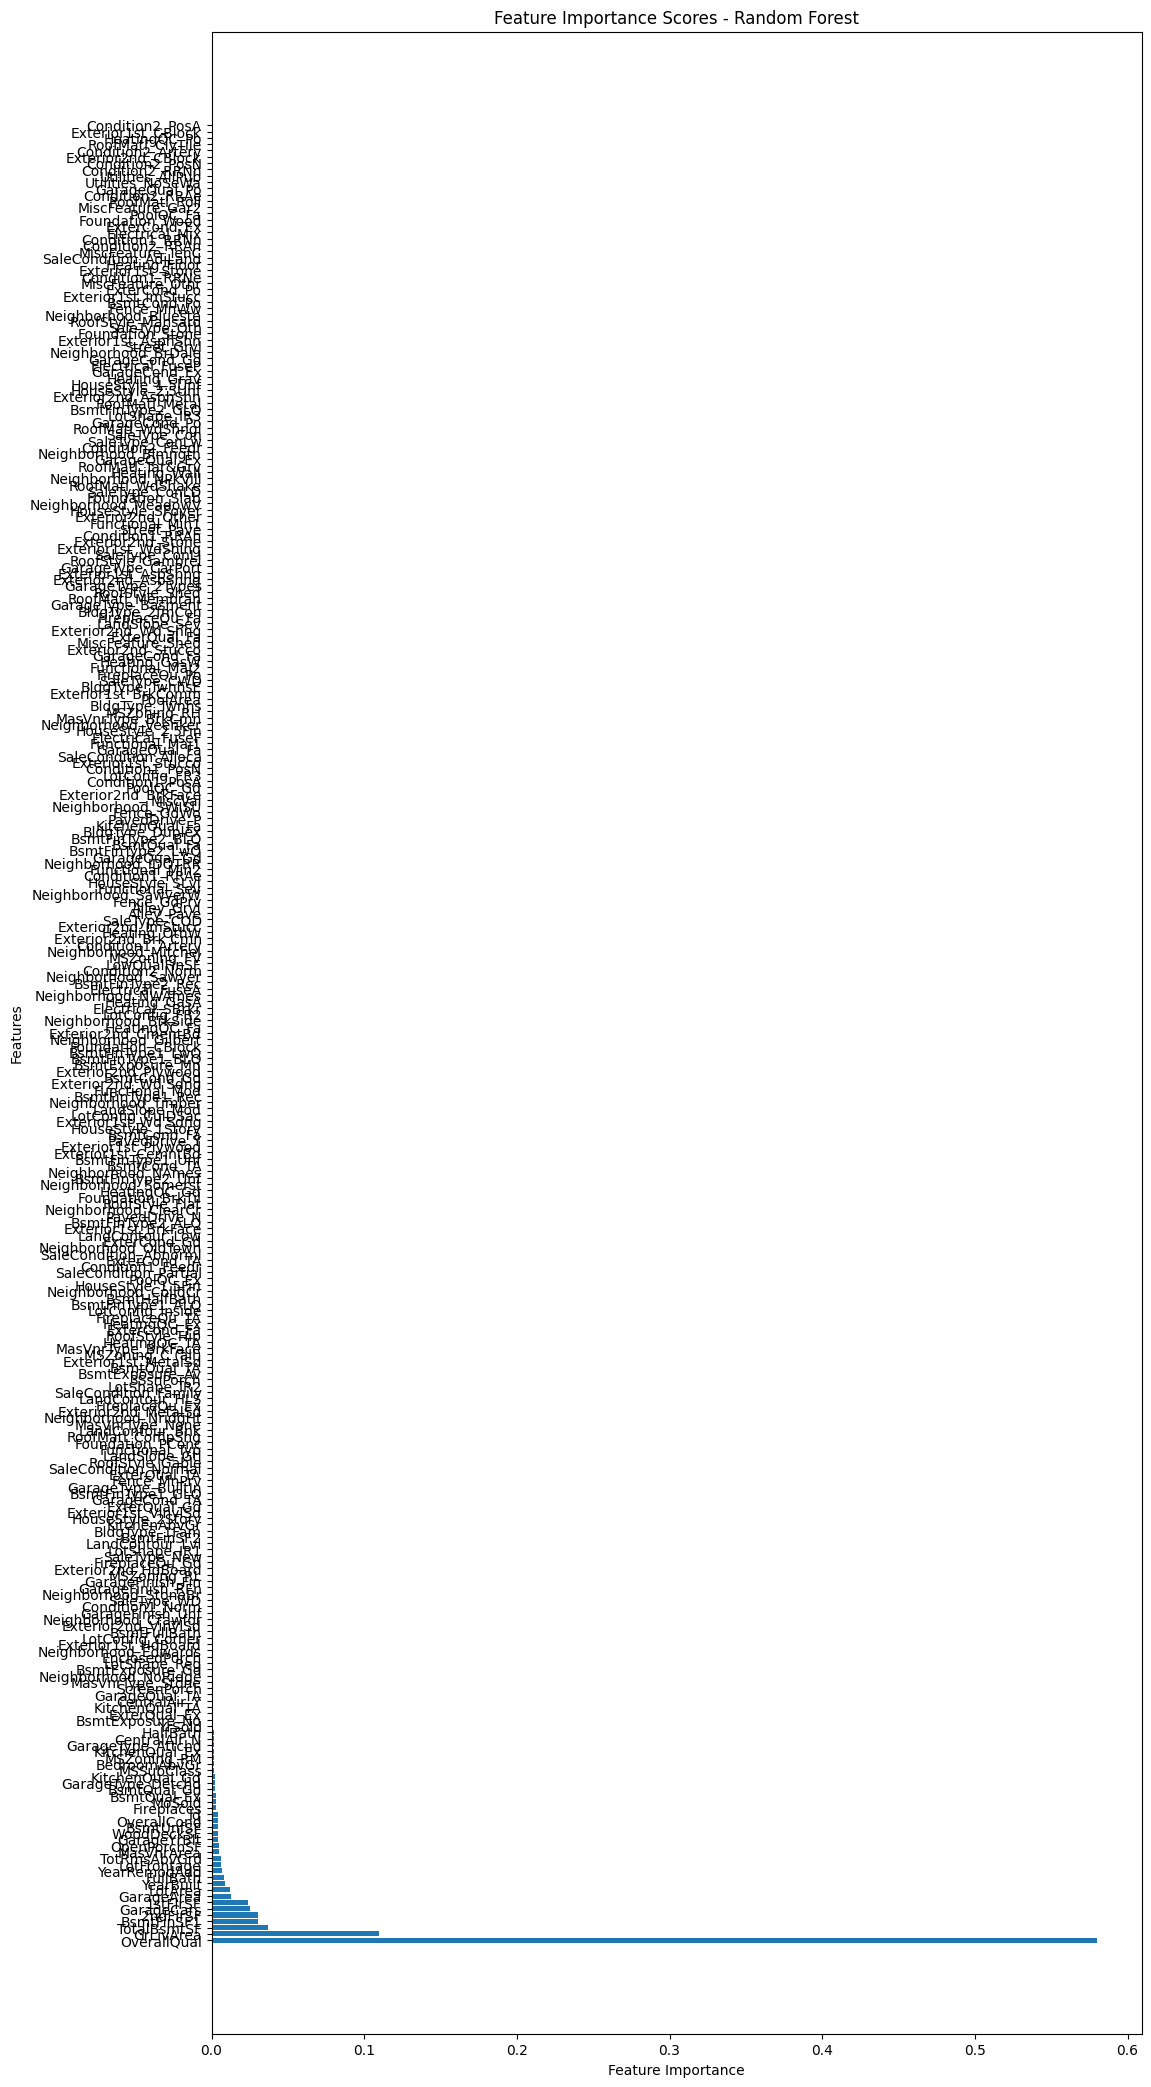

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('train.csv')

# Preprocess the data and split into features and target variable
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

# Perform one-hot encoding for categorical variables
categorical_cols = X.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Use mean imputation, but you can choose another strategy
X_imputed = imputer.fit_transform(X_encoded)

# Create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_imputed, y)

# Get feature importance scores from the Random Forest model
importance_scores = rf.feature_importances_

# Sort features by importance score in descending order
indices = np.argsort(importance_scores)[::-1]
sorted_features = X_encoded.columns[indices]
sorted_scores = importance_scores[indices]

# Plot feature importance
plt.figure(figsize=(12, 26))
plt.barh(range(X_encoded.shape[1]), sorted_scores, align='center')
plt.yticks(range(X_encoded.shape[1]), sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores - Random Forest')
plt.show()

In [19]:
# Get the top 7 most important features
top_10_features = sorted_features[:7]

# Slice the original dataset to include only the top 10 features
X_top_10 = X[top_10_features]

Top 10 Features:
   OverallQual  GrLivArea  TotalBsmtSF  BsmtFinSF1  2ndFlrSF  GarageCars  \
0            7       1710          856         706       854           2   
1            6       1262         1262         978         0           2   
2            7       1786          920         486       866           2   
3            7       1717          756         216       756           3   
4            8       2198         1145         655      1053           3   

   1stFlrSF  GarageArea  LotArea  YearBuilt  
0       856         548     8450       2003  
1      1262         460     9600       1976  
2       920         608    11250       2001  
3       961         642     9550       1915  
4      1145         836    14260       2000  
